In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import  models, optimizers, layers, activations
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2, ResNet50, Xception

import wandb
from wandb.keras import WandbCallback

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
default_parameters = dict(
    data_aug = True,
    pre_trained_model = 'InceptionV3',
    batch_size = 32,
    final_dense = 32,
    final_dropout = 0.2,
    batch_norm = True,
    activation = "relu"
    )

In [3]:
run = wandb.init(config= default_parameters,project="cs6910_Assignment2", entity="arneshbose1")
config = wandb.config

wandb: Currently logged in as: arnesh_neil (use `wandb login --relogin` to force relogin)


In [5]:
image_size = (128,128)
input_size = (128,128,3)
batch_size = config.batch_size

class_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi',
               'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']

train_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [6]:
train_ds = train_gen.flow_from_directory(
    directory='nature_12K/inaturalist_12K/train/',
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="training")

val_ds = train_gen.flow_from_directory(
    directory='nature_12K/inaturalist_12K/train/',
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42,
    subset="validation")

test_ds = train_gen.flow_from_directory(
    directory='nature_12K/inaturalist_12K/val/',
    target_size=image_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42)

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


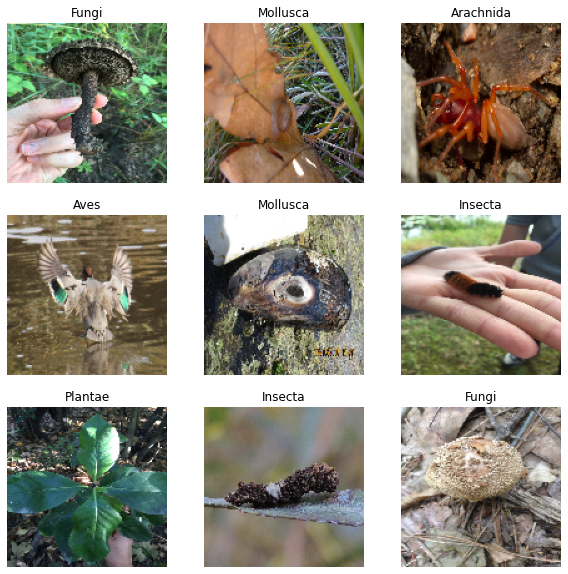

In [7]:
plt.figure(figsize=(10, 10))
images, labels = val_ds.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.where(labels[i] == 1)[0][0]])
    plt.axis("off")
    
plt.show()

In [8]:
def use_pretrained_model(pre_trained_model, batch_size, final_dense, final_dropout, batch_norm, activation):
    if pre_trained_model == 'InceptionV3':
        model = InceptionV3(input_shape = input_size, include_top = False, weights = 'imagenet') # leaving out the last layer since we have only 10 classes
    
    for layer in model.layers:
        layer.trainable = False
        
    x = layers.Flatten()(model.output) # flattening the last layer to a single layer
    x = layers.Dense(final_dense, activation = activation)(x) # adding a dense layer at the end
    x = layers.Dropout(final_dropout)(x) # adding a dropout
    x = layers.Dense(10, tf.nn.softmax)(x) # final softmax function
    
    final_model = Model(model.input,x)
    final_model.summary()
    
    return final_model

In [9]:
pre_trained_model = config.pre_trained_model
batch_size = config.batch_size
final_dense = config.final_dense
final_dropout = config.final_dropout
batch_norm = config.batch_norm
activation = config.activation

In [10]:
model = use_pretrained_model(pre_trained_model, batch_size, final_dense, final_dropout, batch_norm, activation)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[WandbCallback()])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 6, 6, 160)    122880      mixed4[0][0]                     
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 6, 6, 160)    179200      activation_45[0][0]              
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 6, 6, 160)    480         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 6, 6, 160)    480         conv2d_46[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 6, 6, 160)    0           batch_normalization_41[0][0]     
__________

__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 2, 2, 384)    442368      activation_77[0][0]              
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 2, 2, 384)    442368      activation_81[0][0]              
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 2, 2, 384)    442368      activation_81[0][0]              
__________________________________________________________________________________________________
average_pooling2d_7 (AveragePoo (None, 2, 2, 1280)   0           mixed8[0][0]                     
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 2, 2, 320)    409600      mixed8[0][0]                     
__________

Epoch 1/10
282/282 [==============================] - 254s 900ms/step - loss: 2.3611 - accuracy: 0.0934 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 2/10
282/282 [==============================] - 146s 516ms/step - loss: 2.3025 - accuracy: 0.0926 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 3/10
282/282 [==============================] - 152s 540ms/step - loss: 2.3028 - accuracy: 0.0959 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 4/10
282/282 [==============================] - 151s 536ms/step - loss: 2.3026 - accuracy: 0.0948 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 5/10
282/282 [==============================] - 223s 792ms/step - loss: 2.3026 - accuracy: 0.0941 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 6/10
282/282 [==============================] - 229s 814ms/step - loss: 2.3025 - accuracy: 0.0916 - val_loss: 2.3026 - val_accuracy: 0.1001
Epoch 7/10
282/282 [==============================] - 242s 859ms/step - loss: 2.3028 - accuracy: 0.0931 - val_loss: 2.3026 -